# Data Science and Machine Learning Individual Project

# Introduction
The scripts in this notebook explore a dataset of bulk RNA seq data, following cells across a 5 day span under different cell culture conditions. The aim of the work that generated this data was to study the transition of human naive epiblast cells to trophectoderm, a transition that is not observed in the widely used mouse embryo models.


## Cell Culture Conditions
The standard cell culture medium for human naive pluripotent stem cells is PXGL, a culture medium made from the base N2B27 supplemented with PD0325901, XAV939, Go6983 and hLIF. These supplements help to block the differentiation of naive cells, allowing them to be maintained in culture. 


The bulk RNA seq data set was produced from whole-transcriptome sequencing over a 5 day time course in one of the following culture medium conditions:

N2B27 (unsupplemented)

PD0325901, hereafter PD03 (a MEK/ERK inhibitor) 

A83-01, (an Activin/Nodal inhibitor)

PD03 and A83-01 combined.

The paper in which this data was published showed that PD03 and A83-01 combined allow the differentiation of human naive epiblast cells to trophectoderm cells (Human naive epiblast cells possess unrestricted lineage potential, Guo et al (2021)). The data is provided in FPKM (fragments per kilobase of transcript per million fragments). 

# Preparation

## Import relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Read in the data

In [2]:
url = 'https://raw.githubusercontent.com/ehsd737/Data-Science-Assessment/main/BulkRNA_Seq_Data.csv'
data = pd.read_csv(url)
data

,ensemblID,biotype,geneID,PDLGX_hNES1,A8301.D1_hNES1,A8301.D2_hNES1,A8301.D3_hNES1,N2B27.D1_hNES1,N2B27.D2_hNES1,N2B27.D3_hNES1,N2B27.D5_hNES1,PD.D1_hNES1,PD.D2_hNES1,PD.D3_hNES1,PD.D5_hNES1,PDA8301.D1_hNES1,PDA8301.D2_hNES1,PDA8301.D3_hNES1,PDA8301.D5_hNES1
0,ENSG00000000003,protein_coding,TSPAN6,5.05,8.00,8.62,6.76,8.20,9.42,7.51,6.79,5.36,6.30,6.97,5.86,6.00,8.35,7.48,6.67
1,ENSG00000000005,protein_coding,TNMD,0.02,0.08,0.07,0.03,0.12,0.13,0.12,0.04,0.14,0.05,0.07,0.18,0.02,0.04,0.12,0.08
2,ENSG00000000419,protein_coding,DPM1,47.67,38.80,48.26,47.27,40.02,40.67,42.02,38.26,41.14,40.60,37.82,38.43,43.27,39.45,37.40,34.68
3,ENSG00000000457,protein_coding,SCYL3,1.13,1.10,1.10,1.09,1.16,1.05,0.98,1.27,1.01,1.15,1.56,1.96,1.11,1.19,1.82,1.86
4,ENSG00000000460,protein_coding,C1orf112,1.87,1.98,2.32,2.40,2.12,2.04,2.52,2.55,2.10,2.31,3.36,3.73,2.17,2.54,3.93,3.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58879,ENSG00000286268,protein_coding,AF196969.1,0.32,0.34,0.22,0.21,0.56,0.21,0.31,0.30,0.32,0.27,0.35,0.47,0.26,0.28,0.53,0.46
58880,ENSG00000286269,lincRNA,AC092661.1,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00
58881,ENSG00000286270,lincRNA,AL591074.2,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
58882,ENSG00000286271,antisense,AC008945.2,0.00,0.01,0.00,0.01,0.03,0.00,0.01,0.06,0.00,0.01,0.01,0.00,0.03,0.00,0.01,0.00


In [3]:
gene_list = data["geneID"].unique()
print(gene_list)

['TSPAN6' 'TNMD' 'DPM1' ... 'AL591074.2' 'AC008945.2' 'AC093843.2']


# Prepare the dataframe for further analysis 
This involves removing all non-protein-coding gene data, and all zero-read data, and then log2-transforming the dataset. 

Zero read data must be removed as if not it will become undefined after applying the log2 transformation. Alternatively,
a small constant could be added prior to log transformation.

In [4]:
# remove all non protein-coding data
# while this could be interesting to analyse, this is not the core focus of this analysis

filtered_data = data[data["biotype"].str.contains("protein_coding", na=False)]

filtered_data


,ensemblID,biotype,geneID,PDLGX_hNES1,A8301.D1_hNES1,A8301.D2_hNES1,A8301.D3_hNES1,N2B27.D1_hNES1,N2B27.D2_hNES1,N2B27.D3_hNES1,N2B27.D5_hNES1,PD.D1_hNES1,PD.D2_hNES1,PD.D3_hNES1,PD.D5_hNES1,PDA8301.D1_hNES1,PDA8301.D2_hNES1,PDA8301.D3_hNES1,PDA8301.D5_hNES1
0,ENSG00000000003,protein_coding,TSPAN6,5.05,8.00,8.62,6.76,8.20,9.42,7.51,6.79,5.36,6.30,6.97,5.86,6.00,8.35,7.48,6.67
1,ENSG00000000005,protein_coding,TNMD,0.02,0.08,0.07,0.03,0.12,0.13,0.12,0.04,0.14,0.05,0.07,0.18,0.02,0.04,0.12,0.08
2,ENSG00000000419,protein_coding,DPM1,47.67,38.80,48.26,47.27,40.02,40.67,42.02,38.26,41.14,40.60,37.82,38.43,43.27,39.45,37.40,34.68
3,ENSG00000000457,protein_coding,SCYL3,1.13,1.10,1.10,1.09,1.16,1.05,0.98,1.27,1.01,1.15,1.56,1.96,1.11,1.19,1.82,1.86
4,ENSG00000000460,protein_coding,C1orf112,1.87,1.98,2.32,2.40,2.12,2.04,2.52,2.55,2.10,2.31,3.36,3.73,2.17,2.54,3.93,3.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58850,ENSG00000286239,protein_coding,AC093884.1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00
58872,ENSG00000286261,protein_coding,AC022137.3,0.86,0.90,0.33,0.58,0.73,0.59,0.76,0.74,1.18,0.89,1.10,1.14,1.12,1.20,1.19,1.19
58875,ENSG00000286264,protein_coding,AP001453.5,0.03,0.02,0.02,0.01,0.03,0.03,0.00,0.01,0.02,0.03,0.04,0.01,0.01,0.00,0.01,0.00
58876,ENSG00000286265,protein_coding,AC007244.1,0.00,0.11,0.03,0.07,0.09,0.00,0.07,0.00,0.04,0.00,0.00,0.11,0.21,0.03,0.11,0.43


In [5]:
# remove all zero read data
# FPKM data should be log2 - transformed for further analysis, and zero 
# values will cause errors
# see the readme file if you would prefer to keep the zero read data in

filtered_data = filtered_data[(filtered_data != 0).all(axis=1)]

filtered_data

,ensemblID,biotype,geneID,PDLGX_hNES1,A8301.D1_hNES1,A8301.D2_hNES1,A8301.D3_hNES1,N2B27.D1_hNES1,N2B27.D2_hNES1,N2B27.D3_hNES1,N2B27.D5_hNES1,PD.D1_hNES1,PD.D2_hNES1,PD.D3_hNES1,PD.D5_hNES1,PDA8301.D1_hNES1,PDA8301.D2_hNES1,PDA8301.D3_hNES1,PDA8301.D5_hNES1
0,ENSG00000000003,protein_coding,TSPAN6,5.05,8.00,8.62,6.76,8.20,9.42,7.51,6.79,5.36,6.30,6.97,5.86,6.00,8.35,7.48,6.67
1,ENSG00000000005,protein_coding,TNMD,0.02,0.08,0.07,0.03,0.12,0.13,0.12,0.04,0.14,0.05,0.07,0.18,0.02,0.04,0.12,0.08
2,ENSG00000000419,protein_coding,DPM1,47.67,38.80,48.26,47.27,40.02,40.67,42.02,38.26,41.14,40.60,37.82,38.43,43.27,39.45,37.40,34.68
3,ENSG00000000457,protein_coding,SCYL3,1.13,1.10,1.10,1.09,1.16,1.05,0.98,1.27,1.01,1.15,1.56,1.96,1.11,1.19,1.82,1.86
4,ENSG00000000460,protein_coding,C1orf112,1.87,1.98,2.32,2.40,2.12,2.04,2.52,2.55,2.10,2.31,3.36,3.73,2.17,2.54,3.93,3.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58802,ENSG00000286190,protein_coding,AC055839.2,0.11,0.29,0.28,0.36,0.19,0.28,0.31,0.55,0.22,0.24,0.18,0.08,0.14,0.09,0.07,0.05
58804,ENSG00000286192,protein_coding,AC069288.1,0.02,0.04,0.02,0.02,0.04,0.01,0.02,0.04,0.02,0.02,0.03,0.02,0.02,0.01,0.04,0.02
58830,ENSG00000286219,protein_coding,AC242843.1,0.77,0.77,0.68,0.62,0.62,0.59,0.56,0.77,0.58,0.56,0.52,1.27,0.52,0.41,0.64,1.70
58872,ENSG00000286261,protein_coding,AC022137.3,0.86,0.90,0.33,0.58,0.73,0.59,0.76,0.74,1.18,0.89,1.10,1.14,1.12,1.20,1.19,1.19


In [6]:
# make a list of the numeric columns 
# this can then be iterated through to apply the log2 function to the read data
# there are fewer columns containing strings, so a list of string column titles is 
# made and subtracted from the total columns list

col_titles = filtered_data.columns.tolist()
remove_titles = ["ensemblID", "biotype", "geneID"] 

col_titles = [title for title in col_titles if title not in remove_titles]


In [7]:
# create a new dataframe with the identifier column preserved 

# ensemblID can be dropped, as it is an artefact of the data collection method
# and does not store any additional information

log2_data = pd.DataFrame()
log2_data = filtered_data.iloc[:, 2:3]


# add in the numerical values with the log2 function applied
for col in col_titles: 
    log2_data[col] = np.log2(filtered_data[col])

log2_data

,geneID,PDLGX_hNES1,A8301.D1_hNES1,A8301.D2_hNES1,A8301.D3_hNES1,N2B27.D1_hNES1,N2B27.D2_hNES1,N2B27.D3_hNES1,N2B27.D5_hNES1,PD.D1_hNES1,PD.D2_hNES1,PD.D3_hNES1,PD.D5_hNES1,PDA8301.D1_hNES1,PDA8301.D2_hNES1,PDA8301.D3_hNES1,PDA8301.D5_hNES1
0,TSPAN6,2.336283,3.000000,3.107688,2.757023,3.035624,3.235727,2.908813,2.763412,2.422233,2.655352,2.801159,2.550901,2.584963,3.061776,2.903038,2.737687
1,TNMD,-5.643856,-3.643856,-3.836501,-5.058894,-3.058894,-2.943416,-3.058894,-4.643856,-2.836501,-4.321928,-3.836501,-2.473931,-5.643856,-4.643856,-3.058894,-3.643856
2,DPM1,5.575010,5.277985,5.592756,5.562853,5.322649,5.345893,5.393004,5.257765,5.362470,5.343408,5.241077,5.264161,5.435295,5.301953,5.224966,5.116032
3,SCYL3,0.176323,0.137504,0.137504,0.124328,0.214125,0.070389,-0.029146,0.344828,0.014355,0.201634,0.641546,0.970854,0.150560,0.250962,0.863938,0.895303
4,C1orf112,0.903038,0.985500,1.214125,1.263034,1.084064,1.028569,1.333424,1.350497,1.070389,1.207893,1.748461,1.899176,1.117695,1.344828,1.974529,1.646163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58802,AC055839.2,-3.184425,-1.785875,-1.836501,-1.473931,-2.395929,-1.836501,-1.689660,-0.862496,-2.184425,-2.058894,-2.473931,-3.643856,-2.836501,-3.473931,-3.836501,-4.321928
58804,AC069288.1,-5.643856,-4.643856,-5.643856,-5.643856,-4.643856,-6.643856,-5.643856,-4.643856,-5.643856,-5.643856,-5.058894,-5.643856,-5.643856,-6.643856,-4.643856,-5.643856
58830,AC242843.1,-0.377070,-0.377070,-0.556393,-0.689660,-0.689660,-0.761213,-0.836501,-0.377070,-0.785875,-0.836501,-0.943416,0.344828,-0.943416,-1.286304,-0.643856,0.765535
58872,AC022137.3,-0.217591,-0.152003,-1.599462,-0.785875,-0.454032,-0.761213,-0.395929,-0.434403,0.238787,-0.168123,0.137504,0.189034,0.163499,0.263034,0.250962,0.250962


# Data Exploration

Now that we have a 'clean' dataset to work with, we can start to interrogate the data.

First, we can run PCA to identify different lineage trajectories.

Next, we can select some genes of interest for different cell lineages and examine the changes in their gene expression under different conditions.

| Trophectoderm | Hypoblast | Core Epiblast | Primed |
| --- | --- | --- | --- |
| GATA2 | PDGFRA | NANOG | HLA-A |
| GATA3 | FOXA2 | POU5F1 | DUSP6 | 
| NR2F2 | SOX17 | DPPA4| SOX11 |
| TEAD1 | GATA4 | SOX2||
| TEAD3 | COL4A1 | GDF3||
| CLDN4 | COL4A2| DNMT3B||
| OVOL1 ||||
| KRT8 ||||
| KRT18 ||||
| HAND1 ||||
| TP63 ||||



# PCA Analysis

In [8]:
# prepare the total dataset for PCA

scaler = StandardScaler()
all_gene_ids = log2_data['geneID']

all_log2_data = log2_data.drop(columns=['geneID'])

all_data_scaled = scaler.fit_transform(all_log2_data)

plot_data = pd.DataFrame()
plot_data = all_data_scaled.T

In [9]:
# run the PCA

pca = PCA(n_components=4)
pca_result = pca.fit_transform(plot_data)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

print(pca.components_)

Explained variance ratio: [0.53989128 0.20888743 0.06272463 0.04458007]
Cumulative explained variance: [0.53989128 0.74877871 0.81150334 0.8560834 ]
[[-0.00041523  0.00657009 -0.00143184 ...  0.00561327  0.00722444
   0.00633165]
 [ 0.00118724  0.00426803 -0.00025386 ...  0.00519996 -0.00574389
  -0.00137679]
 [ 0.00266208 -0.01084276 -0.0008658  ... -0.01154427  0.00117217
  -0.00431805]
 [-0.00643446  0.00020045 -0.00179859 ... -0.00563236  0.00427227
  -0.00337983]]


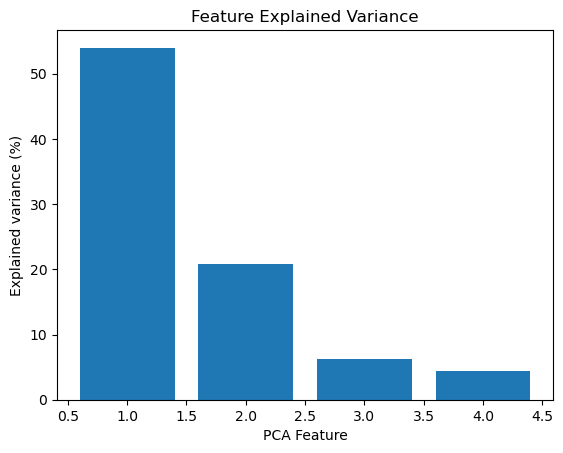

In [10]:
# create a plot to show which principle components explain the most variance in the data

plt.bar(
    range(1,len(pca.explained_variance_)+1),
    (pca.explained_variance_ratio_)*100
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance (%)')
plt.title('Feature Explained Variance')
plt.show()

# this bar plot shows that Feature 1 and Feature 2 explain most of the variance, 
# with Features 3 and 4 contributing relatively little

In [11]:
# define a function to map condition names to group (A8301, N2B27, PD03, PD03+A8301, PDLGX)

def extract_condition_group(condition_name):
    if 'PDLGX' in condition_name:
        return 'PXGL' 
    elif 'PDA8301' in condition_name:
        return 'PD03 and A83-01'
    elif 'A8301' in condition_name:
        return 'A83-01'
    elif 'N2B27' in condition_name:
        return 'N2B27'
    elif 'PD' in condition_name: # PD must be lower in the if-tree than PDLGX or PDLGX conditions are falsely returned as PD 
        return 'PD03'
    else:
        return 'Other'  # For any other condition


In [12]:
# define a function to extract the time label (D1, D2, etc.) from condition names

def extract_time_label(condition_name):
    match = re.search(r'\.D(\d)', condition_name)  # Find the pattern ".D" followed by a number to find the day number
    if match:
        return f'D{match.group(1)}'
    elif 'PDLGX' in condition_name:
        return "D0"
    return None

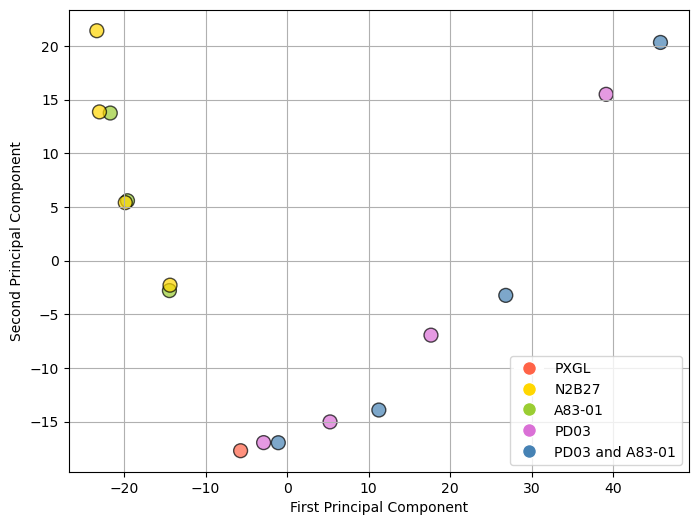

In [27]:
# extract condition names from the columns of log2_data
condition_names = all_log2_data.columns.tolist()  # Extract column names as the condition names

# map condition names to their corresponding groups
condition_groups = [extract_condition_group(condition) for condition in condition_names]


# create a colour map based on condition groups
# colours have been chosen to ensure that they are colourblind-friendly
condition_colours = {
    'PXGL': '#FF6347', 
    'N2B27': '#FFD700',  
    'A83-01': '#9ACD32',  
    'PD03': '#DA70D6',  
    'PD03 and A83-01': '#4682B4',  
    
}

colours = [condition_colours[group] for group in condition_groups]

# Plot the PCA results, colouring the points based on their group
plt.figure(figsize=(8, 6))


scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colours, edgecolor='black', alpha=0.7, s=100)

# Add the figure legends
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
handles = []
for group, colour in condition_colours.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=group, markerfacecolor=colour, markersize=10))

plt.legend(handles=handles)


plt.show()


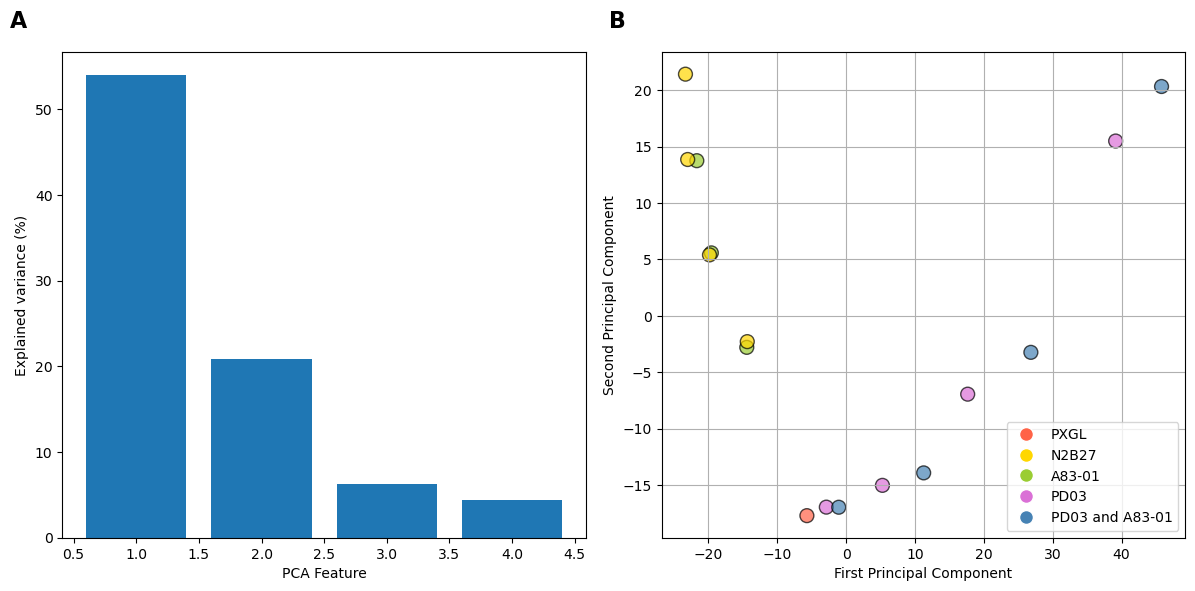

In [28]:
### optional cell ###
# this cell was made to produce a panel with both the PCA feature explanation
# and the PCA itself for the report

# Create a figure with 1 row and 2 columns for the panel
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# --- Plot A: Explained Variance ---
axes[0].bar(
    range(1, len(pca.explained_variance_) + 1),
    (pca.explained_variance_ratio_) * 100
)

axes[0].set_xlabel('PCA Feature')
axes[0].set_ylabel('Explained variance (%)')

# Add label "A" in the top-left corner of the first plot (A)
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes, fontsize=16, fontweight='bold')



# --- Plot B: PCA Scatter Plot ---
scatter = axes[1].scatter(pca_result[:, 0], pca_result[:, 1], c=colours, edgecolor='black', alpha=0.7, s=100)

axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].grid(True)

# Add the figure legends on the second plot (B)
handles = []
for group, colour in condition_colours.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=group, markerfacecolor=colour, markersize=10))

axes[1].legend(handles=handles)

# Add label "B" in the top-left corner of the second plot (B)
axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes, fontsize=16, fontweight='bold')

# Adjust layout to ensure no overlap
plt.tight_layout()

# Show the plot
plt.show()



# Graphing the different genes of interest

In [15]:
# create the different marker subsets

# trophectoderm subset
TE_gene_list = ["GATA2", "GATA3", "NR2F2", "TEAD1", "TEAD3", "CLDN4", "OVOL1", "KRT8", "KRT18", "HAND1", "TP63"]

# hypoblast subset
HYP_gene_list = ["PDGFRA", "FOXA2", "SOX17", "GATA4", "COL4A1", "COL4A2"]

# epiblast subset
EPI_gene_list = ["NANOG", "POU5F1", "DPPA4", "SOX2", "GDF3", "DNMT3B", "KLF4", "KLF17", "PRDM14", "TFAP2C"]

# primed subset
PRI_gene_list = ["HLA-C", "DUSP6", "SOX11"]

# all genes of interest
GOI_gene_list = TE_gene_list + HYP_gene_list + EPI_gene_list + PRI_gene_list


In [16]:
# define a function to iterate through a list of strings
# and pull out rows that contain that string in a given column

def gene_subset(gene_list, data):
    rows_to_add = []  # List to store rows to add
    for gene in gene_list:
        # Filter rows corresponding to the gene and append to the list
        rows_to_add.append(data[data["geneID"] == gene])

    # Concatenate all dataframes from the list
    subset_df = pd.concat(rows_to_add, ignore_index=True) if rows_to_add else pd.DataFrame()

    return subset_df


In [17]:
# use the defined function to pull out each of the genes of interest

GOI_subset = pd.DataFrame()
GOI_subset = gene_subset(GOI_gene_list, log2_data)
GOI_subset.set_index("geneID")

,PDLGX_hNES1,A8301.D1_hNES1,A8301.D2_hNES1,A8301.D3_hNES1,N2B27.D1_hNES1,N2B27.D2_hNES1,N2B27.D3_hNES1,N2B27.D5_hNES1,PD.D1_hNES1,PD.D2_hNES1,PD.D3_hNES1,PD.D5_hNES1,PDA8301.D1_hNES1,PDA8301.D2_hNES1,PDA8301.D3_hNES1,PDA8301.D5_hNES1
geneID,,,,,,,,,,,,,,,,
GATA2,1.400538,1.263034,0.985500,1.819668,1.480265,0.903038,0.831877,1.735522,2.969012,4.219556,6.119771,8.443317,3.485427,5.806582,6.678213,8.249635
GATA3,1.464668,1.422233,1.367371,2.035624,1.627607,1.189034,1.304511,2.084064,3.416840,5.548128,7.187352,8.294621,4.354734,6.747656,7.584737,8.441409
NR2F2,-0.643856,-0.454032,-0.321928,-0.074001,0.176323,-0.340075,-0.577767,-0.643856,-1.058894,-0.358454,2.046142,5.612352,-0.599462,-0.120294,1.948601,5.568336
TEAD1,2.493135,2.333424,2.298658,2.711495,2.687061,2.788686,3.085765,3.682573,3.502076,4.189034,4.807870,6.153805,3.292782,4.452859,4.953731,5.954196
TEAD3,2.364572,2.944858,2.942984,3.258519,2.889474,2.863938,3.300124,3.676944,3.171527,3.179511,4.564988,7.686430,3.094236,3.446256,4.679199,7.050937
CLDN4,-0.104697,0.545968,0.604071,1.356144,0.516015,0.137504,0.739848,0.992768,0.933573,3.127633,5.364572,6.911092,1.744161,4.761285,6.007644,7.147510
OVOL1,0.757023,0.773996,1.104337,1.659925,0.815575,0.799087,1.350497,1.389567,0.903038,1.238787,2.957915,6.072106,1.280956,1.432959,2.147307,4.178715
KRT8,4.318317,6.310704,6.590063,6.499049,6.064366,6.341096,6.284107,6.615593,5.726014,7.092757,7.901832,7.500324,6.024142,7.467769,8.157044,7.930678
KRT18,3.679199,6.736199,7.020258,6.933455,6.428109,6.823622,6.824513,6.955476,5.416164,7.184280,7.948367,7.527868,5.784242,7.635392,8.166063,7.628190


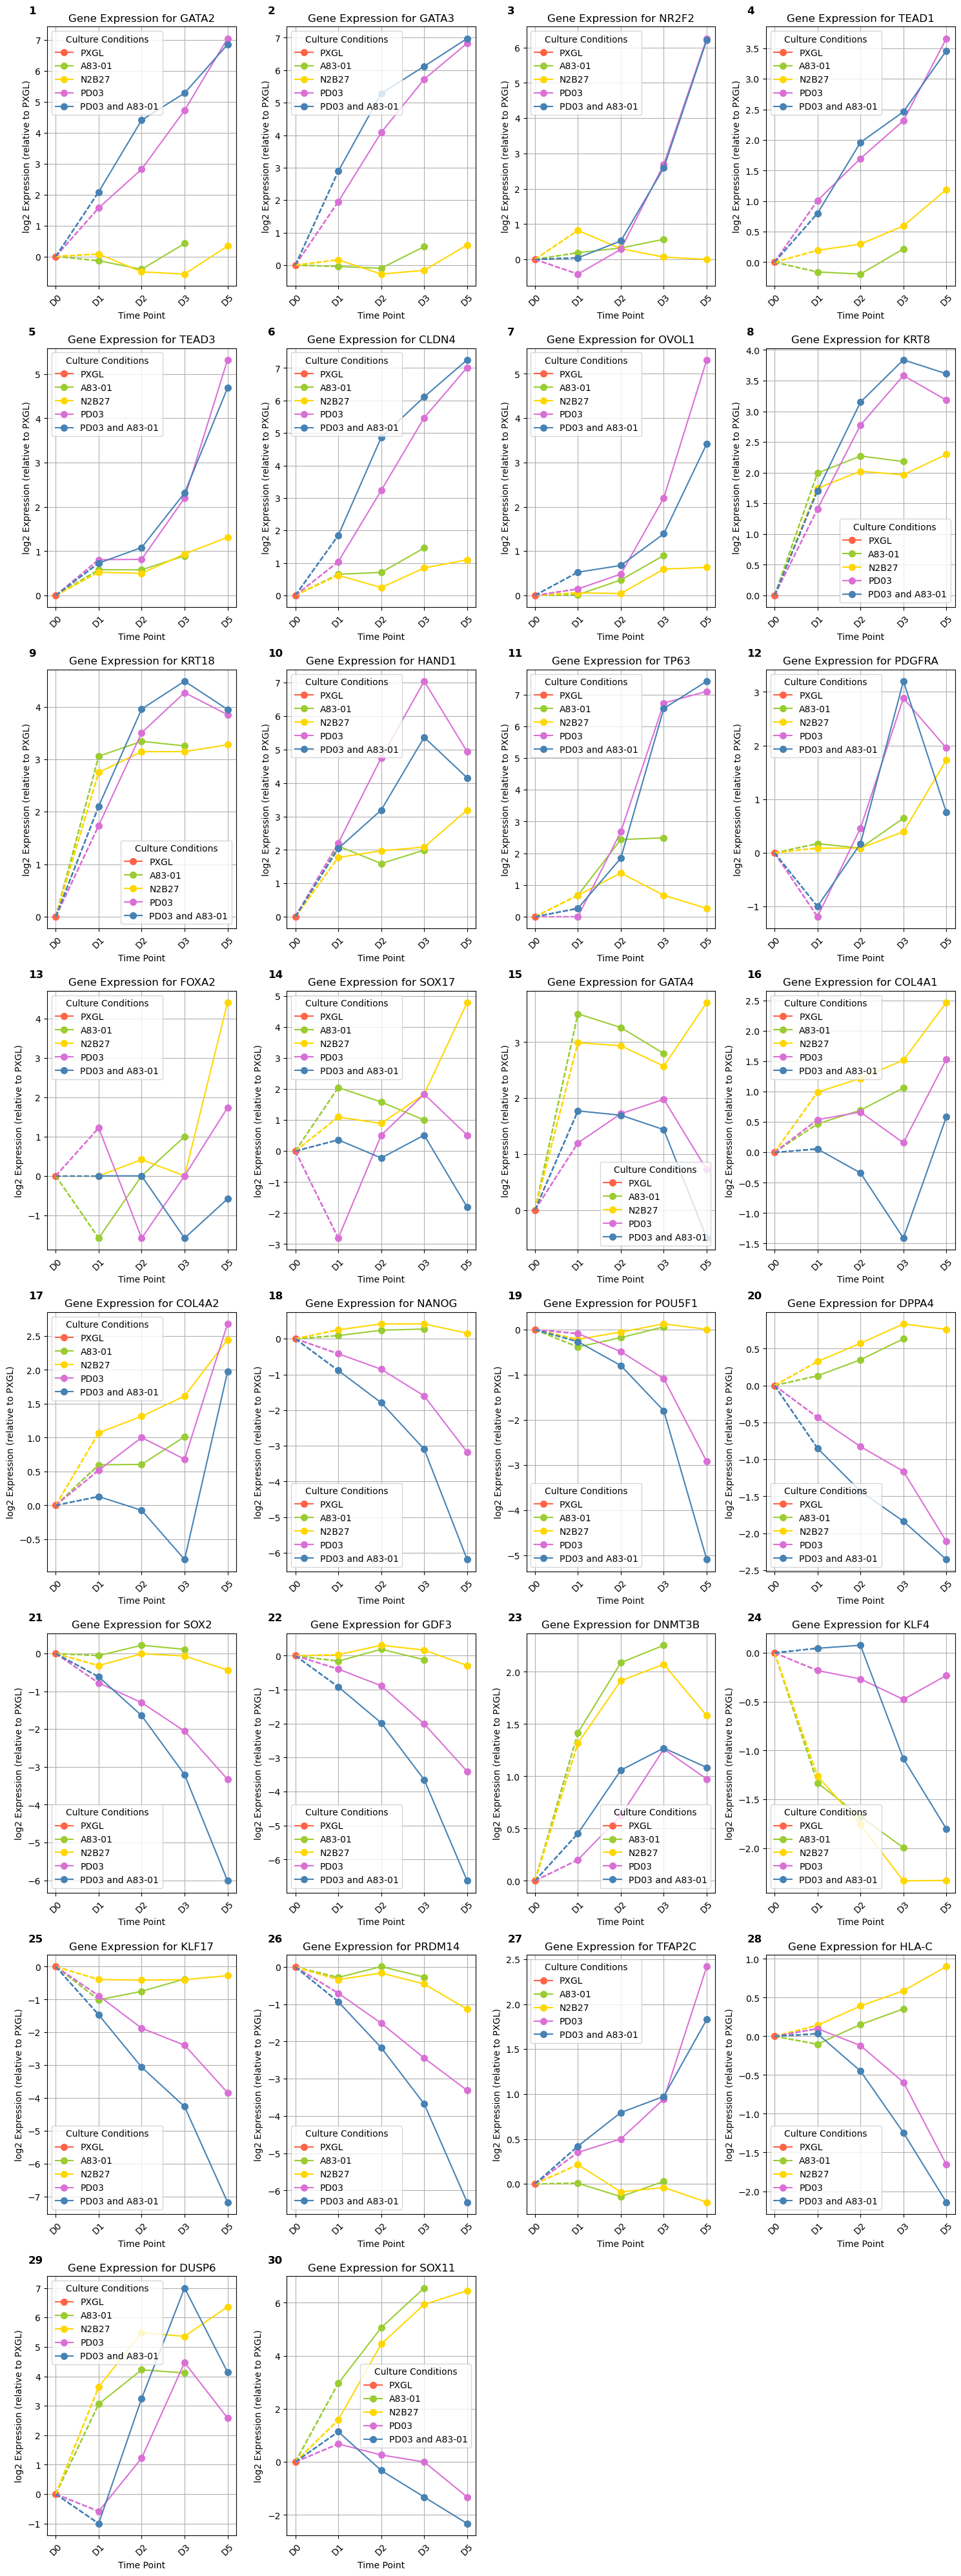

In [24]:
# define the time points (shared for all genes)
time_points = ['D0', 'D1', 'D2', 'D3', 'D5']
GOI_subset.rename(columns={'PDLGX_hNES1': 'PDLGX.D0_hNES1'}, inplace=True)

# define the number of rows and columns for the grid of plots
n_genes = len(GOI_subset.index)
n_cols = 4  # Number of columns for the grid
n_rows = (n_genes // n_cols) + (1 if n_genes % n_cols != 0 else 0)  # Calculate the number of rows needed
                                                                    # for the list of genes

# create the figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust figure size depending on number 
                                                                    # of subplots in the grid

axes = axes.flatten()


# iterate through each gene to plot in the panels
for i, gene in enumerate(GOI_subset.index):
    ax = axes[i]  # get the corresponding subplot for the current gene

    condition_colours_used = {}  # store the colour for each condition group to avoid re-plotting the same group
    
    # get PXGL Day 0 expression value for the current gene
    pxgl_d0_expression = None
    for condition in GOI_subset.columns:
        if "PDLGX" in condition and "D0" in condition:  # Find PXGL D0 for the current gene
            column_name = f'{condition.split(".")[0]}.D0_hNES1'
            if column_name in GOI_subset.columns:
                pxgl_d0_expression = GOI_subset.loc[gene, column_name]
                break

    # if PXGL D0 data was not found, skip this gene; there is no "baseline" to compare against
    if pxgl_d0_expression is None:
        print(f"Skipping gene {gene} because PXGL D0 expression is missing.")
        continue

    # iterate through each condition and plot the data
    for condition in GOI_subset.columns:
      
        # extract the time point (e.g., D1, D2, D3, D5) from the condition name
        time_label = extract_time_label(condition)

        if time_label and time_label in time_points:
            
            # extract the data for the current condition and gene for all time points
            expression_values = []
            for time_point in time_points:
                
                # construct the expected column name
                column_name = f'{condition.split(".")[0]}.{time_point}_hNES1'
                
                # check if the column exists in the dataframe before trying to access it
                if column_name in GOI_subset.columns:
                    # subtract PXGL D0 expression to make all time points relative to PXGL D0
                    expression_values.append(GOI_subset.loc[gene, column_name] - pxgl_d0_expression)
                else:
                    expression_values.append(None)  # Append None if the column does not exist

            # only plot the condition group once, using the first time point to define the colour
            condition_group = extract_condition_group(condition)
            
            # ensure the line is only plotted once per condition group 
            if condition_group not in condition_colours_used:
                # Get the colour from the predefined condition_colours dictionary
                colour = condition_colours.get(condition_group, 'gray')  # Default to gray if no colour is defined
                condition_colours_used[condition_group] = colour
                
                # plot the line for the current condition
                
                ax.plot(time_points, expression_values, marker='o', label=condition_group, color=colour, markersize=7)

            # Connect D1 points to PXGL D0 for all conditions
            if "D1" in time_points and pxgl_d0_expression is not None:
                condition_d1_expression = expression_values[time_points.index('D1')]
                if condition_d1_expression is not None:
                    ax.plot([time_points.index('D0'), time_points.index('D1')], [0, condition_d1_expression], color=colour, linestyle='--')
   
    # Add titles and legends
    ax.set_title(f'Gene Expression for {GOI_subset.loc[gene, "geneID"]}')  
    ax.set_xlabel('Time Point')
    ax.set_ylabel('log2 Expression (relative to PXGL)')
    ax.set_xticks(time_points)
    ax.set_xticklabels(time_points, rotation=45)
    ax.legend(title='Culture Conditions')
    ax.grid(True)
    ax.text(-0.1, 1.05, f'{i + 1}', transform=ax.transAxes, fontsize=12, fontweight='bold')
    
    
# Hide any unused axes (if the number of genes is less than n_rows * n_cols)
for x in range(n_genes, len(axes)):
    axes[x].axis('off')

# Show the plots
plt.tight_layout()
plt.show()

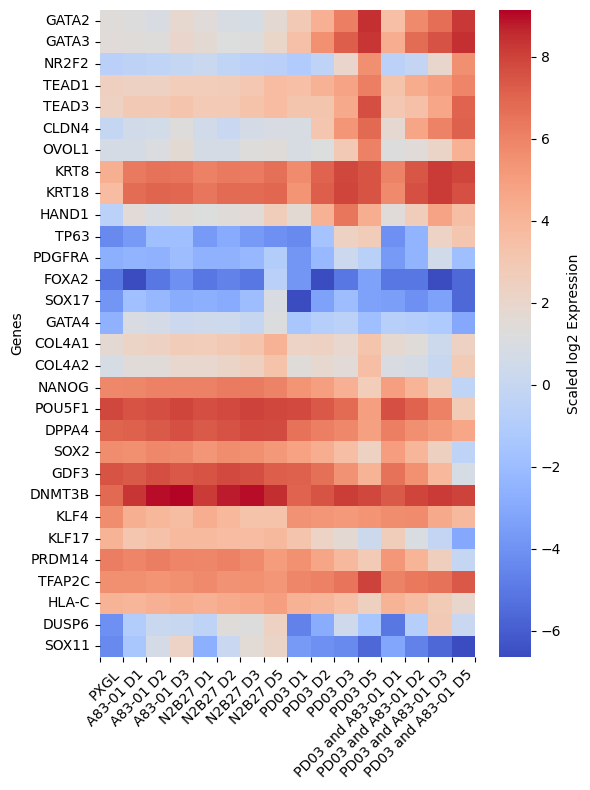

In [20]:
# prepare GOI_subset for plotting
GOI_subset_plot = GOI_subset.drop(columns=['geneID'])
GOI_subset_plot.index = GOI_subset['geneID'] 



# create the heatmap 
plt.figure(figsize=(6, 8))  
sns.heatmap(GOI_subset_plot, annot=False, cmap='coolwarm', cbar_kws={'label': 'Scaled log2 Expression'})

# set the title and labels
plt.ylabel('Genes') 

# change the x axis labels so that they are meaningful to the viewer
condition_labels = [f"{extract_condition_group(col)} {extract_time_label(col)}" for col in GOI_subset.columns]
condition_labels[0] = ''
condition_labels[1] = 'PXGL'

# rotate the tick labels for conditions (x-axis) and genes (y-axis)
plt.xticks(ticks=range(len(GOI_subset.columns)), labels=condition_labels, rotation=45, ha='right') 


plt.tight_layout()

# show the plot
plt.show()
